# **Image denoising**

## Импорт инструментов

In [ ]:
import os
import random
import numpy as np
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset

import cv2
from PIL import Image
from matplotlib import pyplot as plt
from math import log10
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

In [2]:
# Размер изображений
size = 128
# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---

## DnCNN

In [3]:
def sequential(*args):
    """Advanced nn.Sequential.

    Args:
        nn.Sequential, nn.Module

    Returns:
        nn.Sequential
    """
    if len(args) == 1:
        if isinstance(args[0], OrderedDict):
            raise NotImplementedError('sequential does not support OrderedDict input.')
        return args[0]  # No sequential is needed.
    modules = []
    for module in args:
        if isinstance(module, nn.Sequential):
            for submodule in module.children():
                modules.append(submodule)
        elif isinstance(module, nn.Module):
            modules.append(module)
    return nn.Sequential(*modules)


def conv(
    in_channels=64, out_channels=64, kernel_size=3, stride=1
    , padding=1, bias=True, mode='CBR', negative_slope=0.2):
    L = []
    for t in mode:
        if t == 'C':
            L.append(nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=kernel_size, stride=stride, padding=padding, bias=bias))
        elif t == 'T':
            L.append(nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=kernel_size, stride=stride, padding=padding, bias=bias))
        elif t == 'B':
            L.append(nn.BatchNorm2d(out_channels, momentum=0.9, eps=1e-04, affine=True))
        elif t == 'I':
            L.append(nn.InstanceNorm2d(out_channels, affine=True))
        elif t == 'R':
            L.append(nn.ReLU(inplace=True))
        elif t == 'r':
            L.append(nn.ReLU(inplace=False))
        elif t == 'L':
            L.append(nn.LeakyReLU(negative_slope=negative_slope, inplace=True))
        elif t == 'l':
            L.append(nn.LeakyReLU(negative_slope=negative_slope, inplace=False))
        elif t == '2':
            L.append(nn.PixelShuffle(upscale_factor=2))
        elif t == '3':
            L.append(nn.PixelShuffle(upscale_factor=3))
        elif t == '4':
            L.append(nn.PixelShuffle(upscale_factor=4))
        elif t == 'U':
            L.append(nn.Upsample(scale_factor=2, mode='nearest'))
        elif t == 'u':
            L.append(nn.Upsample(scale_factor=3, mode='nearest'))
        elif t == 'v':
            L.append(nn.Upsample(scale_factor=4, mode='nearest'))
        elif t == 'M':
            L.append(nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=0))
        elif t == 'A':
            L.append(nn.AvgPool2d(kernel_size=kernel_size, stride=stride, padding=0))
        else:
            raise NotImplementedError('Undefined type: '.format(t))
    return sequential(*L)

In [4]:
class DnCNN(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nc=64, nb=17, act_mode='BR'):
        """
        # ------------------------------------
        in_nc: channel number of input
        out_nc: channel number of output
        nc: channel number
        nb: total number of conv layers
        act_mode: batch norm + activation function; 'BR' means BN+ReLU.
        # ------------------------------------
        Batch normalization and residual learning are
        beneficial to Gaussian denoising (especially
        for a single noise level).
        The residual of a noisy image corrupted by additive white
        Gaussian noise (AWGN) follows a constant
        Gaussian distribution which stablizes batch
        normalization during training.
        # ------------------------------------
        """
        super(DnCNN, self).__init__()
        assert 'R' in act_mode or 'L' in act_mode, 'Examples of activation function: R, L, BR, BL, IR, IL'
        bias = True

        m_head = conv(in_nc, nc, mode='C'+act_mode[-1], bias=bias)
        m_body = [conv(nc, nc, mode='C'+act_mode, bias=bias) for _ in range(nb-2)]
        m_tail = conv(nc, out_nc, mode='C', bias=bias)

        self.model = sequential(m_head, *m_body, m_tail)

    def forward(self, x):
        n = self.model(x)
        return x-n

In [6]:
class UniversalDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, gaussian_noise_level=(0, 55), transform=None):
        self.image_folder = image_folder
        self.gaussian_noise_level = gaussian_noise_level
        self.transforms = transform
        self.image_files = [
            f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))
        ]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_folder, image_file)
        
        # Загрузка изображения
        clean_image = Image.open(image_path).convert('RGB')
        clean_image = np.array(clean_image)
        
        # Применение преобразований, если они есть
        if self.transforms:
            clean_image = self.transforms(image=clean_image)['image']
        
        # Создание и добавление гауссовского шума
        noisy_image = clean_image.copy().astype(np.float32)
        gaussian_noise = np.zeros(clean_image.shape, dtype=np.float32)
        
        sigma = random.randint(self.gaussian_noise_level[0], self.gaussian_noise_level[1])
        gaussian_noise += np.random.normal(0.0, sigma, clean_image.shape).astype(np.float32)
        
        noisy_image += gaussian_noise
        
        # Приведение изображений к формату Tensor
        clean_image = torch.Tensor(clean_image).permute(2, 0, 1)  # [C, H, W]
        noisy_image = torch.Tensor(noisy_image).permute(2, 0, 1)  # [C, H, W]
        gaussian_noise = torch.Tensor(gaussian_noise).permute(2, 0, 1)  # [C, H, W]
        
        return clean_image, gaussian_noise, noisy_image

In [30]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [31]:
train_transforms = A.Compose([
    A.Resize(height=size, width=size, p=1),
#     A.OneOf([
#         A.GaussNoise(var_limit=(10, 100), p=1),
#         A.ISONoise(intensity=(0.3, 0.9), p=1),
#         A.MultiplicativeNoise(p=1)
#     ]),
#     ToTensorV2()
])

# train_dataset = UniversalDataset(
#     '/kaggle/input/coco-2017-dataset/coco2017/train2017',
#     transform=train_transforms
# )

# val_dataset = UniversalDataset(
#     '/kaggle/input/coco-2017-dataset/coco2017/test2017',
#     transform=train_transforms
# )

dataset = UniversalDataset(
    '/kaggle/input/coco-2017-dataset/coco2017/test2017',
    transform=train_transforms
)

datasets = train_val_dataset(dataset)
train_dataset = datasets['train']
val_dataset = datasets['val']

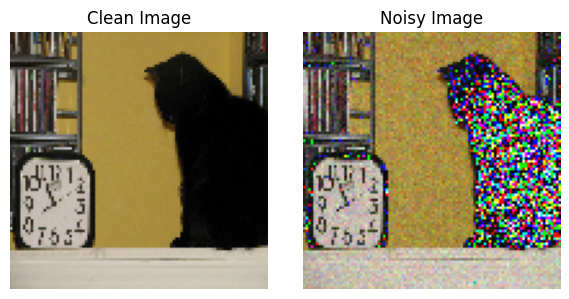

In [133]:
# Пример получения изображений из вашего набора данных
clean_image, _, noisy_image = train_dataset[100]

# Преобразование тензоров в массивы NumPy и приведение значений к диапазону [0, 255]
clean_image_np = clean_image.permute(1, 2, 0).numpy().astype(np.uint8)
noisy_image_np = noisy_image.permute(1, 2, 0).numpy().astype(np.uint8)

# Создание фигуры и подграфиков
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Отображение чистого изображения
ax[0].imshow(clean_image_np)
ax[0].set_title('Clean Image')
ax[0].axis('off')  # Отключение осей

# Отображение зашумленного изображения
ax[1].imshow(noisy_image_np)
ax[1].set_title('Noisy Image')
ax[1].axis('off')  # Отключение осей

# Отображение графиков
plt.tight_layout()
plt.show()

In [134]:
batch_size = 32

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=True,
    pin_memory=True
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=False,
    pin_memory=True
)

In [ ]:
def trainer(
    model=model, criterion=criterion,
    optimizer=optimizer, epochs=5, rep_freq=100):
    # mse
    train_mse_history = []
    valid_mse_history = []
    # psnr
    train_psnr_history = []
    valid_psnr_history = []

    for epoch in range(1, epochs+1):
        epoch_train_mse = 0
        epoch_train_psnr = 0
        model.train()
        for iteration, data in enumerate(tqdm(train_dataloader, desc="Training")):

            clean_imgs, _, noisy_imgs = data
            clean_imgs, noisy_imgs = clean_imgs.to(device)/255, noisy_imgs.to(device)/255

            output = model(noisy_imgs)

            train_mse = criterion(output, clean_imgs)
            epoch_train_mse += train_mse.item()
            train_psnr = 10 * log10(1 / train_mse.item())
            epoch_train_psnr += train_psnr

            train_mse.backward()
            optimizer.step()
            optimizer.zero_grad()

            if ((iteration+1) % rep_freq == 0) or (iteration == 0):
                print("===> Epoch[{}]({}/{}): "
                    "MSE Loss: {:.6f}".format(epoch, iteration+1,
                                          len(train_dataloader), 
                                          train_mse.item()))
        # Считаем среднюю ошибку за эпоху
        avg_train_mse = epoch_train_mse / len(train_dataloader)
        train_mse_history.append(avg_train_mse)
        avg_train_psnr = epoch_train_psnr / len(train_dataloader)
        train_psnr_history.append(avg_train_psnr)
        print("===> Epoch {} Complete: "
            "Avg. MSE Loss: {:.6f}".format(epoch, avg_train_mse)
             )
        print(f"===> Avg. PSNR Loss: {avg_train_psnr:.6f} dB")


        epoch_val_mse = 0
        epoch_val_psnr = 0
        model.eval()
        with torch.no_grad():
            for data in tqdm(val_dataloader, desc="Validation"):
                clean_imgs, _, noisy_imgs = data
                clean_imgs, noisy_imgs = clean_imgs.to(device)/255, noisy_imgs.to(device)/255
                output = model(noisy_imgs)
                val_mse = criterion(output, clean_imgs)
                epoch_val_mse += val_mse.item()
                val_psnr = 10 * log10(1 / val_mse.item())
                epoch_val_psnr += val_psnr

        avg_val_mse = epoch_val_mse / len(val_dataloader)
        valid_mse_history.append(avg_val_mse)
        avg_val_psnr = epoch_val_psnr / len(val_dataloader)
        valid_psnr_history.append(avg_val_psnr)
        print(f"===> Avg. MSE Loss: {avg_val_mse:.6f}"
             )
        print(f"===> Avg. PSNR Loss: {avg_val_psnr:.6f} dB")
        
    return (
        train_mse_history, valid_mse_history,
        train_psnr_history, valid_psnr_history
    )

In [139]:
print('Number of packages in the train_dataloader:', len(train_dataloader))
print('Number of packages in the val_dataloader:  ', len(val_dataloader))

Number of packages in the train_dataloader: 954
Number of packages in the val_dataloader:   318


In [146]:
DnCNN_model = DnCNN().to(device)
criterion = nn.MSELoss()
lr = 1e-4
optimizer = optim.AdamW(DnCNN_model.parameters(), lr=lr)

tr_mse_hstry, vl_mse_hstry, tr_psnr_hstry, vl_psnr_hstry = trainer(
    model=DnCNN_model, criterion=criterion,
    optimizer=optimizer, epochs=5, rep_freq=150
)

Training:   0%|          | 1/954 [00:00<10:26,  1.52it/s]

===> Epoch[1](1/954): MSE Loss: 0.249647


Training:  16%|█▌        | 150/954 [00:26<02:48,  4.78it/s]

===> Epoch[1](150/954): MSE Loss: 0.018165


Training:  31%|███▏      | 300/954 [00:52<02:16,  4.78it/s]

===> Epoch[1](300/954): MSE Loss: 0.010387


Training:  47%|████▋     | 450/954 [01:19<01:45,  4.79it/s]

===> Epoch[1](450/954): MSE Loss: 0.012927


Training:  63%|██████▎   | 600/954 [01:45<01:14,  4.77it/s]

===> Epoch[1](600/954): MSE Loss: 0.006932


Training:  79%|███████▊  | 750/954 [02:11<00:42,  4.78it/s]

===> Epoch[1](750/954): MSE Loss: 0.005517


Training:  94%|█████████▍| 900/954 [02:37<00:11,  4.79it/s]

===> Epoch[1](900/954): MSE Loss: 0.004703


Training: 100%|██████████| 954/954 [02:46<00:00,  5.72it/s]


===> Epoch 1 Complete: Avg. MSE Loss: 0.011718
===> Avg. PSNR Loss: 20.145047 dB


Validation: 100%|██████████| 318/318 [00:33<00:00,  9.60it/s]


===> Avg. MSE Loss: 0.023505
===> Avg. PSNR Loss: 16.334355 dB


Training:   0%|          | 1/954 [00:00<10:37,  1.50it/s]

===> Epoch[2](1/954): MSE Loss: 0.004889


Training:  16%|█▌        | 150/954 [00:26<02:48,  4.78it/s]

===> Epoch[2](150/954): MSE Loss: 0.004498


Training:  31%|███▏      | 300/954 [00:52<02:17,  4.77it/s]

===> Epoch[2](300/954): MSE Loss: 0.004080


Training:  47%|████▋     | 450/954 [01:19<01:45,  4.78it/s]

===> Epoch[2](450/954): MSE Loss: 0.004031


Training:  63%|██████▎   | 600/954 [01:45<01:14,  4.78it/s]

===> Epoch[2](600/954): MSE Loss: 0.003883


Training:  79%|███████▊  | 750/954 [02:11<00:42,  4.78it/s]

===> Epoch[2](750/954): MSE Loss: 0.004327


Training:  94%|█████████▍| 900/954 [02:37<00:11,  4.79it/s]

===> Epoch[2](900/954): MSE Loss: 0.003730


Training: 100%|██████████| 954/954 [02:46<00:00,  5.71it/s]


===> Epoch 2 Complete: Avg. MSE Loss: 0.004382
===> Avg. PSNR Loss: 23.643321 dB


Validation: 100%|██████████| 318/318 [00:32<00:00,  9.93it/s]


===> Avg. MSE Loss: 0.004254
===> Avg. PSNR Loss: 23.740129 dB


Training:   0%|          | 1/954 [00:00<11:01,  1.44it/s]

===> Epoch[3](1/954): MSE Loss: 0.003294


Training:  16%|█▌        | 150/954 [00:26<02:48,  4.78it/s]

===> Epoch[3](150/954): MSE Loss: 0.004060


Training:  31%|███▏      | 300/954 [00:52<02:16,  4.79it/s]

===> Epoch[3](300/954): MSE Loss: 0.003470


Training:  47%|████▋     | 450/954 [01:19<01:45,  4.78it/s]

===> Epoch[3](450/954): MSE Loss: 0.004215


Training:  63%|██████▎   | 600/954 [01:45<01:13,  4.79it/s]

===> Epoch[3](600/954): MSE Loss: 0.003078


Training:  79%|███████▊  | 750/954 [02:11<00:42,  4.78it/s]

===> Epoch[3](750/954): MSE Loss: 0.003394


Training:  94%|█████████▍| 900/954 [02:37<00:11,  4.79it/s]

===> Epoch[3](900/954): MSE Loss: 0.003077


Training: 100%|██████████| 954/954 [02:46<00:00,  5.72it/s]


===> Epoch 3 Complete: Avg. MSE Loss: 0.003583
===> Avg. PSNR Loss: 24.511600 dB


Validation: 100%|██████████| 318/318 [00:31<00:00, 10.11it/s]


===> Avg. MSE Loss: 0.003877
===> Avg. PSNR Loss: 24.148955 dB


Training:   0%|          | 1/954 [00:00<10:28,  1.52it/s]

===> Epoch[4](1/954): MSE Loss: 0.003351


Training:  16%|█▌        | 150/954 [00:26<02:48,  4.79it/s]

===> Epoch[4](150/954): MSE Loss: 0.003206


Training:  31%|███▏      | 300/954 [00:52<02:16,  4.78it/s]

===> Epoch[4](300/954): MSE Loss: 0.003118


Training:  47%|████▋     | 450/954 [01:18<01:45,  4.79it/s]

===> Epoch[4](450/954): MSE Loss: 0.002967


Training:  63%|██████▎   | 600/954 [01:45<01:14,  4.78it/s]

===> Epoch[4](600/954): MSE Loss: 0.002933


Training:  79%|███████▊  | 750/954 [02:11<00:42,  4.79it/s]

===> Epoch[4](750/954): MSE Loss: 0.003858


Training:  94%|█████████▍| 900/954 [02:37<00:11,  4.78it/s]

===> Epoch[4](900/954): MSE Loss: 0.003399


Training: 100%|██████████| 954/954 [02:46<00:00,  5.72it/s]


===> Epoch 4 Complete: Avg. MSE Loss: 0.003252
===> Avg. PSNR Loss: 24.926788 dB


Validation: 100%|██████████| 318/318 [00:31<00:00, 10.17it/s]


===> Avg. MSE Loss: 0.003100
===> Avg. PSNR Loss: 25.122347 dB


Training:   0%|          | 1/954 [00:00<10:34,  1.50it/s]

===> Epoch[5](1/954): MSE Loss: 0.003708


Training:  16%|█▌        | 150/954 [00:26<02:47,  4.79it/s]

===> Epoch[5](150/954): MSE Loss: 0.002983


Training:  31%|███▏      | 300/954 [00:52<02:16,  4.79it/s]

===> Epoch[5](300/954): MSE Loss: 0.003196


Training:  47%|████▋     | 450/954 [01:18<01:45,  4.78it/s]

===> Epoch[5](450/954): MSE Loss: 0.003017


Training:  63%|██████▎   | 600/954 [01:45<01:14,  4.78it/s]

===> Epoch[5](600/954): MSE Loss: 0.003734


Training:  79%|███████▊  | 750/954 [02:11<00:42,  4.79it/s]

===> Epoch[5](750/954): MSE Loss: 0.002563


Training:  94%|█████████▍| 900/954 [02:37<00:11,  4.78it/s]

===> Epoch[5](900/954): MSE Loss: 0.002518


Training: 100%|██████████| 954/954 [02:46<00:00,  5.72it/s]


===> Epoch 5 Complete: Avg. MSE Loss: 0.003054
===> Avg. PSNR Loss: 25.197735 dB


Validation: 100%|██████████| 318/318 [00:31<00:00, 10.02it/s]

===> Avg. MSE Loss: 0.003076
===> Avg. PSNR Loss: 25.156576 dB


In [148]:
def loss_hist_plot(train_mse, val_mse, train_psnr, val_psnr):
    # Создание графиков
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # График для MSE loss
    axs[0].plot(train_mse, label='Train MSE Loss', color='blue')
    axs[0].plot(val_mse, label='Valid MSE Loss', color='red')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('MSE Loss')
    axs[0].legend()
    axs[0].set_title('MSE Loss History')

    # График для PSNR
    axs[1].plot(train_psnr, label='Train PSNR', color='green')
    axs[1].plot(val_psnr, label='Valid PSNR', color='orange')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('PSNR')
    axs[1].legend()
    axs[1].set_title('PSNR History')

    # Показать графики
    plt.tight_layout()
    plt.show()

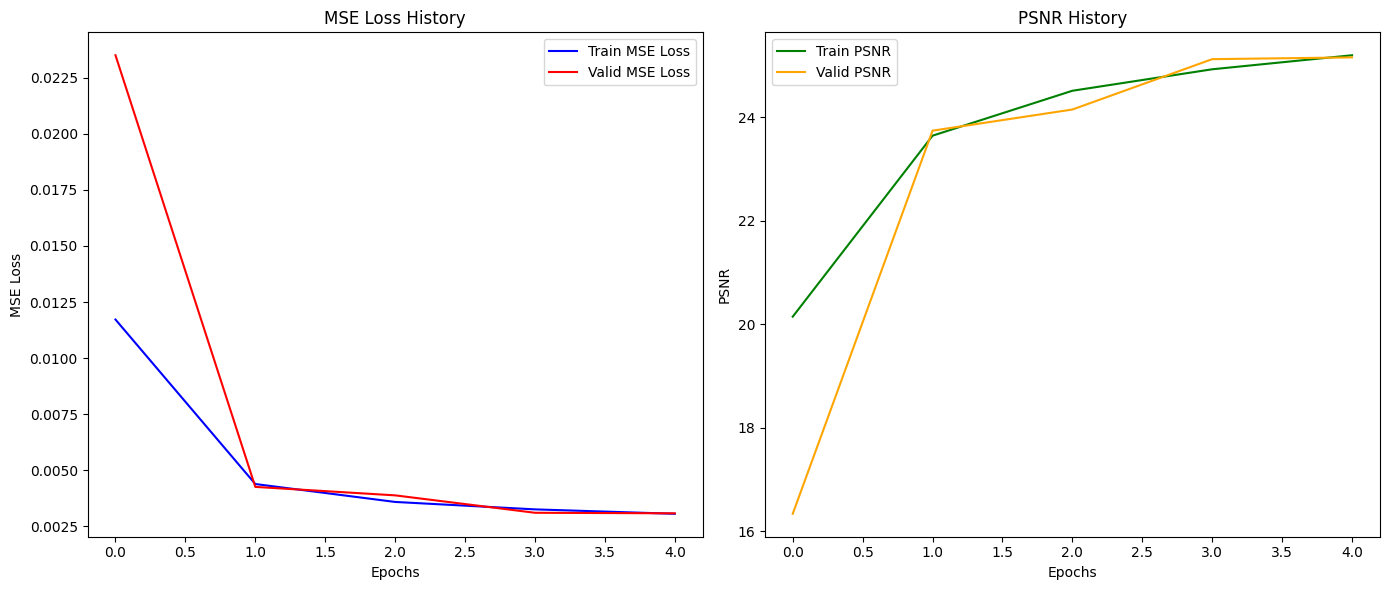

In [149]:
loss_hist_plot(tr_mse_hstry, vl_mse_hstry, tr_psnr_hstry, vl_psnr_hstry)

In [162]:
def batch_visualize(model, val_dataloader, device, batch_index=0, num_images=4):
    # Проверка, что num_images кратно 4
    if num_images % 4 != 0:
        raise ValueError("num_images должно быть кратно 4")
    
    model.eval()
    with torch.no_grad():
        # Переход к конкретному пакету
        for i, data in enumerate(val_dataloader):
            if i == batch_index:
                clean_imgs, _, noisy_imgs = data
                clean_imgs, noisy_imgs = clean_imgs.to(device)/255, noisy_imgs.to(device)/255
                output = model(noisy_imgs)
            
                # Преобразование в numpy
                output_images = (output * 255).cpu().numpy().astype(np.uint8)
                noisy_images = (noisy_imgs * 255).cpu().numpy().astype(np.uint8)
                clean_images = (clean_imgs * 255).cpu().numpy().astype(np.uint8)
            
                # Отбор изображений в зависимости от num_images
                noisy_images = noisy_images[:num_images]
                output_images = output_images[:num_images]
                clean_images = clean_images[:num_images]
            
                # Определение количества рядов
                num_rows = (num_images // 4) * 3
                
                # Создание фигуры с нужными подграфиками
                fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 5))
                
                # Обработка каждого изображения
                for r in range(num_rows):
                    for c in range(4):
                        idx = (r * 4 + c) % num_images
                        if r < (num_images // 4):
                            # Первый ряд: изображения из noisy_images
                            axs[r, c].imshow(noisy_images[idx].transpose(1, 2, 0))
                        elif r < 2 * (num_images // 4):
                            # Второй ряд: изображения из output_images
                            axs[r, c].imshow(output_images[idx].transpose(1, 2, 0))
                        else:
                            # Третий ряд: изображения из clean_images
                            axs[r, c].imshow(clean_images[idx].transpose(1, 2, 0))
                        
                        axs[r, c].axis('off')
                
                plt.tight_layout()
                plt.show()
                
                # Выход из цикла после визуализации нужного пакета
                break

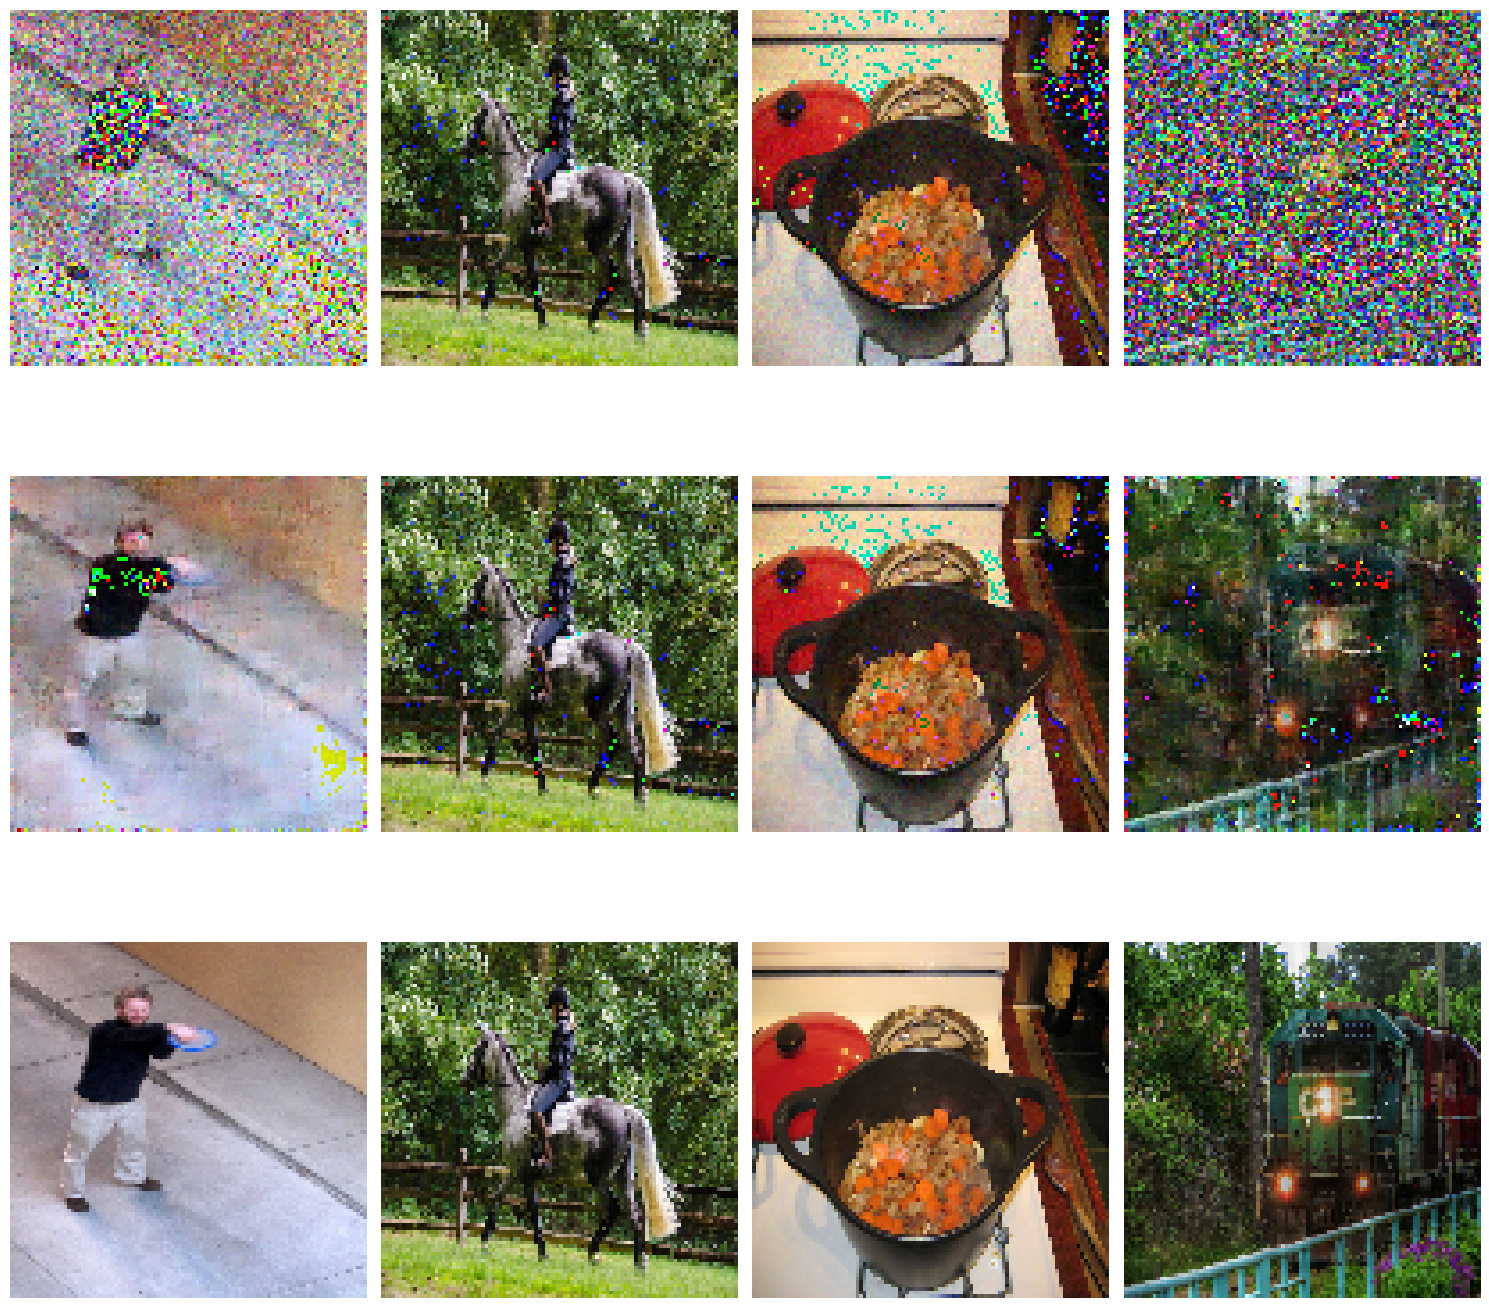

In [163]:
batch_visualize(DnCNN_model, val_dataloader, device, batch_index=2, num_images=4)

---

## UNet

In [217]:
def upsample_pixelshuffle(
    in_channels=64, out_channels=3, kernel_size=3,
    stride=1, padding=1, bias=True, mode='2R', negative_slope=0.2):
    assert len(mode)<4 and mode[0] in ['2', '3', '4'], 'mode examples: 2, 2R, 2BR, 3, ..., 4BR.'
    up1 = conv(
        in_channels,
        out_channels * (int(mode[0]) ** 2),
        kernel_size, stride, padding,
        bias, mode='C'+mode,
        negative_slope=negative_slope
    )
    return up1


def upsample_upconv(
    in_channels=64, out_channels=3, kernel_size=3,
    stride=1, padding=1, bias=True, mode='2R', negative_slope=0.2):
    assert len(mode)<4 and mode[0] in ['2', '3', '4'], 'mode examples: 2, 2R, 2BR, 3, ..., 4BR'
    if mode[0] == '2':
        uc = 'UC'
    elif mode[0] == '3':
        uc = 'uC'
    elif mode[0] == '4':
        uc = 'vC'
    mode = mode.replace(mode[0], uc)
    up1 = conv(
        in_channels, out_channels,kernel_size,
        stride, padding, bias, mode=mode,
        negative_slope=negative_slope
    )
    return up1


def upsample_convtranspose(
    in_channels=64, out_channels=3, kernel_size=2,
    stride=2, padding=0, bias=True, mode='2R', negative_slope=0.2):
    assert len(mode)<4 and mode[0] in ['2', '3', '4'], 'mode examples: 2, 2R, 2BR, 3, ..., 4BR.'
    kernel_size = int(mode[0])
    stride = int(mode[0])
    mode = mode.replace(mode[0], 'T')
    up1 = conv(
        in_channels, out_channels, kernel_size,
        stride, padding, bias, mode, negative_slope
    )
    return up1


def downsample_strideconv(
    in_channels=64, out_channels=64, kernel_size=2,
    stride=2, padding=0, bias=True, mode='2R', negative_slope=0.2):
    assert len(mode)<4 and mode[0] in ['2', '3', '4'], 'mode examples: 2, 2R, 2BR, 3, ..., 4BR.'
    kernel_size = int(mode[0])
    stride = int(mode[0])
    mode = mode.replace(mode[0], 'C')
    down1 = conv(
        in_channels, out_channels, kernel_size,
        stride, padding, bias, mode, negative_slope
    )
    return down1

In [222]:
class UNet(nn.Module):
    def __init__(
        self, in_nc=3, out_nc=3, nc=[64, 128, 256, 512],
        nb=2, act_mode='R', downsample_mode='strideconv',
        upsample_mode='convtranspose'):
        super(UNet, self).__init__()

        self.m_head = conv(in_nc, nc[0], mode='C'+act_mode[-1])

        # downsample
        if downsample_mode == 'avgpool':
            downsample_block = downsample_avgpool
        elif downsample_mode == 'maxpool':
            downsample_block = downsample_maxpool
        elif downsample_mode == 'strideconv':
            downsample_block = downsample_strideconv
        else:
            raise NotImplementedError(
                'downsample mode [{:s}] is not found'.format(downsample_mode)
            )

        self.m_down1 = sequential(
            *[conv(nc[0], nc[0], mode='C'+act_mode) for _ in range(nb)],
            downsample_block(nc[0], nc[1], mode='2'+act_mode)
        )
        self.m_down2 = sequential(
            *[conv(nc[1], nc[1], mode='C'+act_mode) for _ in range(nb)],
            downsample_block(nc[1], nc[2], mode='2'+act_mode)
        )
        self.m_down3 = sequential(
            *[conv(nc[2], nc[2], mode='C'+act_mode) for _ in range(nb)],
            downsample_block(nc[2], nc[3], mode='2'+act_mode)
        )
        self.m_body  = sequential(
            *[conv(nc[3], nc[3], mode='C'+act_mode) for _ in range(nb+1)]
        )

        # upsample
        if upsample_mode == 'upconv':
            upsample_block = upsample_upconv
        elif upsample_mode == 'pixelshuffle':
            upsample_block = upsample_pixelshuffle
        elif upsample_mode == 'convtranspose':
            upsample_block = upsample_convtranspose
        else:
            raise NotImplementedError(
                'upsample mode [{:s}] is not found'.format(upsample_mode)
            )

        self.m_up3 = sequential(
            upsample_block(nc[3], nc[2], mode='2'+act_mode),
            *[conv(nc[2], nc[2], mode='C'+act_mode) for _ in range(nb)]
        )
        self.m_up2 = sequential(
            upsample_block(nc[2], nc[1], mode='2'+act_mode),
            *[conv(nc[1], nc[1], mode='C'+act_mode) for _ in range(nb)]
        )
        self.m_up1 = sequential(
            upsample_block(nc[1], nc[0], mode='2'+act_mode),
            *[conv(nc[0], nc[0], mode='C'+act_mode) for _ in range(nb)]
        )

        self.m_tail = conv(nc[0], out_nc, bias=True, mode='C')

    def forward(self, x0):

        x1 = self.m_head(x0)
        x2 = self.m_down1(x1)
        x3 = self.m_down2(x2)
        x4 = self.m_down3(x3)
        x = self.m_body(x4)
        x = self.m_up3(x+x4)
        x = self.m_up2(x+x3)
        x = self.m_up1(x+x2)
        x = self.m_tail(x+x1) + x0

        return x

In [225]:
UNet_model = UNet().to(device)
criterion = nn.MSELoss()
lr = 1e-4
optimizer = optim.AdamW(UNet_model.parameters(), lr=lr)

tr_mse_hstry, vl_mse_hstry, tr_psnr_hstry, vl_psnr_hstry = trainer(
    model=UNet_model, criterion=criterion,
    optimizer=optimizer, epochs=5, rep_freq=150
)

Training:   0%|          | 1/954 [00:00<13:21,  1.19it/s]

===> Epoch[1](1/954): MSE Loss: 0.049349


Training:  16%|█▌        | 150/954 [00:23<02:20,  5.72it/s]

===> Epoch[1](150/954): MSE Loss: 0.009630


Training:  31%|███▏      | 300/954 [00:45<01:54,  5.71it/s]

===> Epoch[1](300/954): MSE Loss: 0.005488


Training:  47%|████▋     | 450/954 [01:07<01:28,  5.71it/s]

===> Epoch[1](450/954): MSE Loss: 0.005308


Training:  63%|██████▎   | 600/954 [01:30<01:01,  5.73it/s]

===> Epoch[1](600/954): MSE Loss: 0.003887


Training:  79%|███████▊  | 750/954 [01:52<00:35,  5.72it/s]

===> Epoch[1](750/954): MSE Loss: 0.004243


Training:  94%|█████████▍| 900/954 [02:14<00:09,  5.71it/s]

===> Epoch[1](900/954): MSE Loss: 0.004030


Training: 100%|██████████| 954/954 [02:22<00:00,  6.69it/s]


===> Epoch 1 Complete: Avg. MSE Loss: 0.006781
===> Avg. PSNR Loss: 22.436977 dB


Validation: 100%|██████████| 318/318 [00:39<00:00,  8.07it/s]


===> Avg. MSE Loss: 0.004052
===> Avg. PSNR Loss: 23.944559 dB


Training:   0%|          | 1/954 [00:00<11:46,  1.35it/s]

===> Epoch[2](1/954): MSE Loss: 0.003871


Training:  16%|█▌        | 150/954 [00:22<02:20,  5.71it/s]

===> Epoch[2](150/954): MSE Loss: 0.003408


Training:  31%|███▏      | 300/954 [00:45<01:54,  5.72it/s]

===> Epoch[2](300/954): MSE Loss: 0.003315


Training:  47%|████▋     | 450/954 [01:07<01:28,  5.70it/s]

===> Epoch[2](450/954): MSE Loss: 0.003125


Training:  63%|██████▎   | 600/954 [01:29<01:01,  5.71it/s]

===> Epoch[2](600/954): MSE Loss: 0.003610


Training:  79%|███████▊  | 750/954 [01:52<00:35,  5.72it/s]

===> Epoch[2](750/954): MSE Loss: 0.002213


Training:  94%|█████████▍| 900/954 [02:14<00:09,  5.72it/s]

===> Epoch[2](900/954): MSE Loss: 0.002681


Training: 100%|██████████| 954/954 [02:22<00:00,  6.69it/s]


===> Epoch 2 Complete: Avg. MSE Loss: 0.003327
===> Avg. PSNR Loss: 24.825967 dB


Validation: 100%|██████████| 318/318 [00:36<00:00,  8.77it/s]


===> Avg. MSE Loss: 0.003203
===> Avg. PSNR Loss: 24.975576 dB


Training:   0%|          | 1/954 [00:00<11:28,  1.38it/s]

===> Epoch[3](1/954): MSE Loss: 0.004112


Training:  16%|█▌        | 150/954 [00:22<02:20,  5.71it/s]

===> Epoch[3](150/954): MSE Loss: 0.003496


Training:  31%|███▏      | 300/954 [00:45<01:54,  5.71it/s]

===> Epoch[3](300/954): MSE Loss: 0.002762


Training:  47%|████▋     | 450/954 [01:07<01:28,  5.70it/s]

===> Epoch[3](450/954): MSE Loss: 0.002090


Training:  63%|██████▎   | 600/954 [01:29<01:01,  5.71it/s]

===> Epoch[3](600/954): MSE Loss: 0.002462


Training:  79%|███████▊  | 750/954 [01:52<00:35,  5.72it/s]

===> Epoch[3](750/954): MSE Loss: 0.002538


Training:  94%|█████████▍| 900/954 [02:14<00:09,  5.71it/s]

===> Epoch[3](900/954): MSE Loss: 0.002538


Training: 100%|██████████| 954/954 [02:22<00:00,  6.70it/s]


===> Epoch 3 Complete: Avg. MSE Loss: 0.002791
===> Avg. PSNR Loss: 25.579737 dB


Validation: 100%|██████████| 318/318 [00:36<00:00,  8.67it/s]


===> Avg. MSE Loss: 0.002710
===> Avg. PSNR Loss: 25.712316 dB


Training:   0%|          | 1/954 [00:00<11:12,  1.42it/s]

===> Epoch[4](1/954): MSE Loss: 0.002649


Training:  16%|█▌        | 150/954 [00:22<02:20,  5.72it/s]

===> Epoch[4](150/954): MSE Loss: 0.002502


Training:  31%|███▏      | 300/954 [00:45<01:54,  5.71it/s]

===> Epoch[4](300/954): MSE Loss: 0.002621


Training:  47%|████▋     | 450/954 [01:07<01:28,  5.72it/s]

===> Epoch[4](450/954): MSE Loss: 0.002886


Training:  63%|██████▎   | 600/954 [01:29<01:01,  5.73it/s]

===> Epoch[4](600/954): MSE Loss: 0.003174


Training:  79%|███████▊  | 750/954 [01:52<00:35,  5.71it/s]

===> Epoch[4](750/954): MSE Loss: 0.002910


Training:  94%|█████████▍| 900/954 [02:14<00:09,  5.71it/s]

===> Epoch[4](900/954): MSE Loss: 0.003074


Training: 100%|██████████| 954/954 [02:22<00:00,  6.69it/s]


===> Epoch 4 Complete: Avg. MSE Loss: 0.002626
===> Avg. PSNR Loss: 25.844099 dB


Validation: 100%|██████████| 318/318 [00:36<00:00,  8.78it/s]


===> Avg. MSE Loss: 0.002563
===> Avg. PSNR Loss: 25.953364 dB


Training:   0%|          | 1/954 [00:00<11:54,  1.33it/s]

===> Epoch[5](1/954): MSE Loss: 0.003490


Training:  16%|█▌        | 150/954 [00:22<02:22,  5.64it/s]

===> Epoch[5](150/954): MSE Loss: 0.003330


Training:  31%|███▏      | 300/954 [00:45<01:54,  5.70it/s]

===> Epoch[5](300/954): MSE Loss: 0.002472


Training:  47%|████▋     | 450/954 [01:07<01:28,  5.71it/s]

===> Epoch[5](450/954): MSE Loss: 0.002422


Training:  63%|██████▎   | 600/954 [01:29<01:02,  5.70it/s]

===> Epoch[5](600/954): MSE Loss: 0.002126


Training:  79%|███████▊  | 750/954 [01:52<00:35,  5.72it/s]

===> Epoch[5](750/954): MSE Loss: 0.002605


Training:  94%|█████████▍| 900/954 [02:14<00:09,  5.72it/s]

===> Epoch[5](900/954): MSE Loss: 0.002644


Training: 100%|██████████| 954/954 [02:22<00:00,  6.69it/s]


===> Epoch 5 Complete: Avg. MSE Loss: 0.002527
===> Avg. PSNR Loss: 26.014390 dB


Validation: 100%|██████████| 318/318 [00:36<00:00,  8.80it/s]

===> Avg. MSE Loss: 0.002544
===> Avg. PSNR Loss: 25.979979 dB


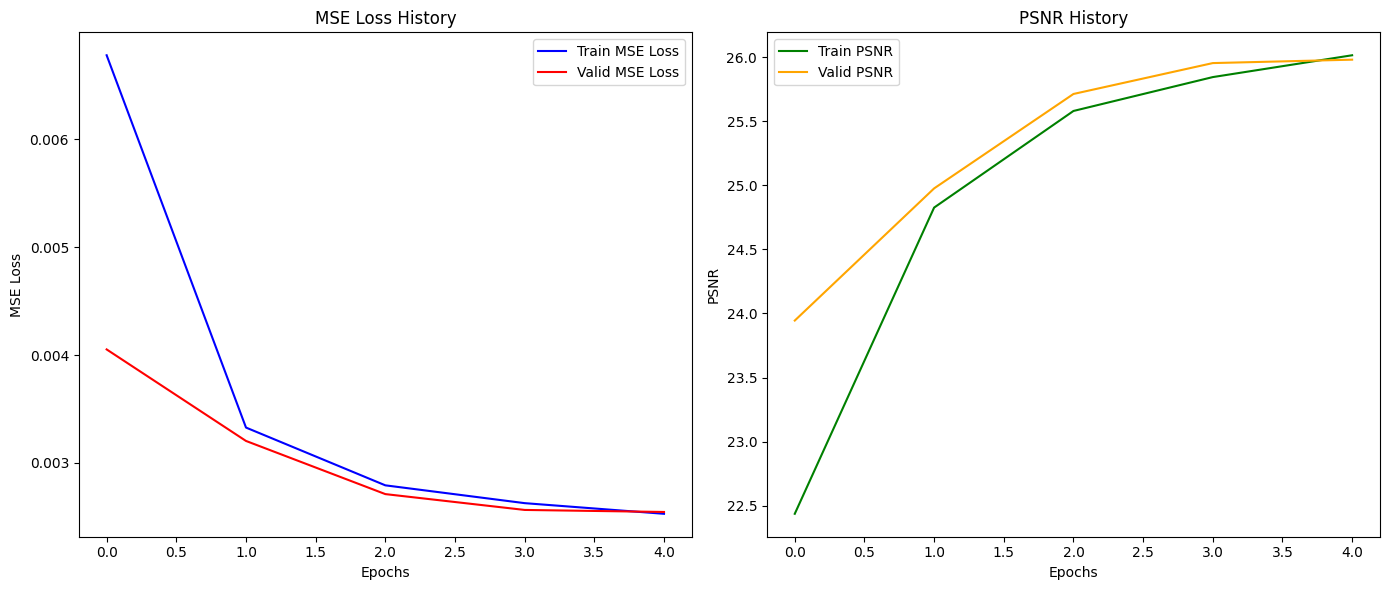

In [226]:
loss_hist_plot(tr_mse_hstry, vl_mse_hstry, tr_psnr_hstry, vl_psnr_hstry)

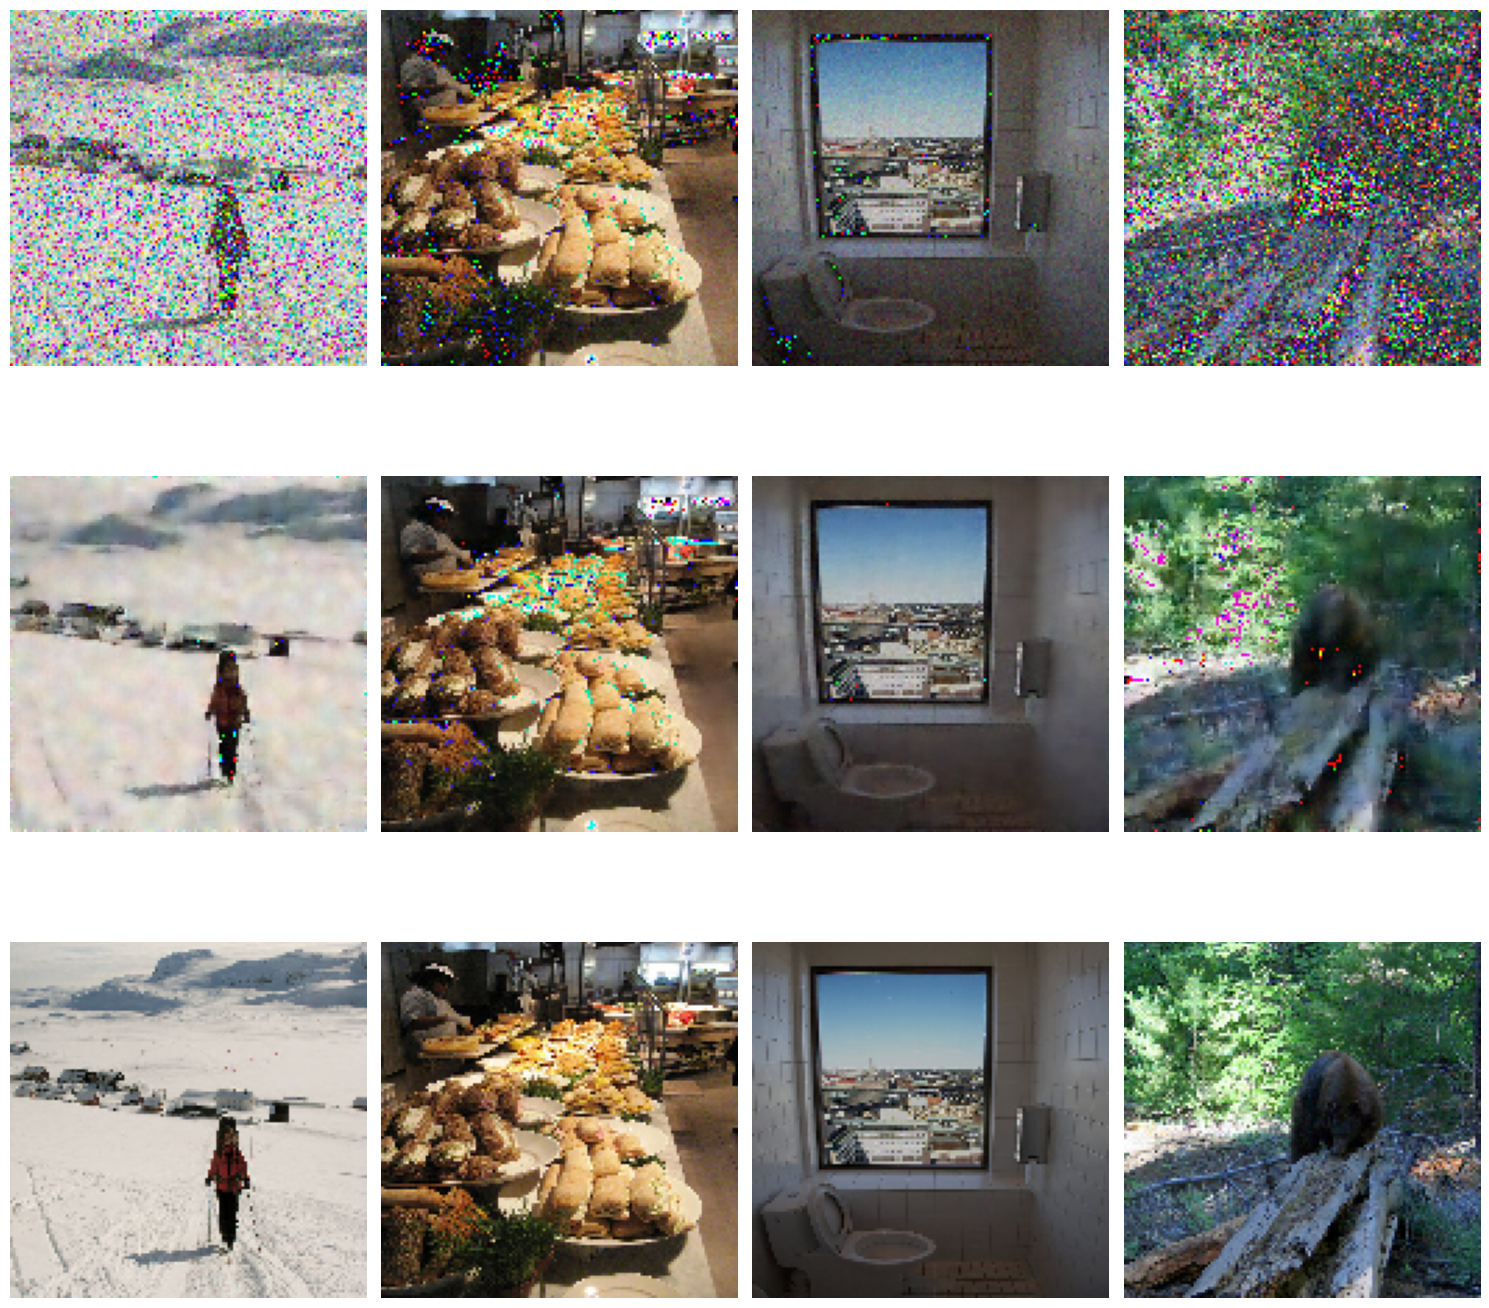

In [228]:
batch_visualize(UNet_model, val_dataloader, device, batch_index=0, num_images=4)